# Create dataset

In [2]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import colorsys

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
files = [file for file in os.listdir("./LGA_data") if file.endswith(".xls")]
all_files = pd.DataFrame()

for file in files:
    df = pd.read_excel("./LGA_data/" + file)
    all_files = pd.concat([all_files, df])

C:\Users\johnn\AppData\Local\Temp\ipykernel_29396\912865602.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_files = pd.concat([all_files, df])


# Preprocessing and filtering

In [4]:
num_rows = all_files.shape[0]
print("Number of rows before cleaning:", num_rows)
all_files.dropna(subset=['Street Display'], inplace=True)
num_rows = all_files.shape[0]
print("Number of rows after dropping NAs:", num_rows)
all_files.drop_duplicates(inplace=True)
num_rows = all_files.shape[0]
print("Number of rows after dropping duplicates:", num_rows)
# Find the indices of the rows with sale price equal to 0
indices_to_drop = all_files[all_files['Sale Price'] == 0].index
# Drop the rows from the dataset
all_files.drop(indices_to_drop, inplace=True)
num_rows = all_files.shape[0]
print("Number of rows after dropping obs with sales price = 0:", num_rows)


Number of rows before cleaning: 874193
Number of rows after dropping NAs: 873680
Number of rows after dropping duplicates: 873610
Number of rows after dropping obs with sales price = 0: 526075


In [5]:
all_files = all_files.reset_index(drop=True)
df = all_files
# df.to_csv('alldata.csv', index=False)

In [6]:
df.columns

Index(['Disclaimer', 'Building Name', 'Street Display',
       'Alternate Street Display', 'Other', 'Unit', 'Number', 'Street Name',
       'Locality', 'Postcode', 'Alt. Street', 'Alt. Locality',
       'Legal Description', 'Volume/Folio', 'Vendor Names', 'Vendor Address',
       'Purchaser Names', 'Purchaser Address', 'Volume Folio', 'Parish',
       'Office Name', 'Agent Name', 'First Price', 'Change %', 'Last Price',
       'Change %.1', 'Days To Sell', 'Sale Price', 'Sale Date',
       'Settlement Date', 'Sale Type', 'Area', 'Building Area', 'Bedrooms',
       'Bathrooms', 'Car Parks', 'Property Type', 'Land Use', 'Zoning',
       'Main Rooms', 'Build Year', 'Building Style', 'Storeys', 'Wall Type',
       'Roof Type', 'Improvements', 'Hundred', 'Sale Category',
       'Document Status', 'Parties Related Flag', 'Parties Related',
       'Valuation Date', 'Valuation Amount', 'LGA', 'Dealing Number',
       'Government Number', 'Parent Government Number', 'PDS ID', 'Sale ID',
       

In [ ]:
# Drop columns: 'Disclaimer', 'Building Name' and 25 other columns
df = df.drop(columns=['Disclaimer', 'Building Name', 'Alternate Street Display', 'Other', 'Alt. Street', 'Alt. Locality', 'Volume/Folio', 'Volume Folio', 'Parish', 'Building Area', 'Main Rooms', 'Build Year', 'Building Style', 'Storeys', 'Wall Type', 'Roof Type', 'Improvements', 'Hundred', 'Sale Category', 'Document Status', 'Parties Related Flag', 'Parties Related', 'Valuation Date', 'Valuation Amount', 'Parent Government Number', 'Load Date', 'Property ID'])

df = df[df["Property Type"] != "Commercial"]
df = df[df["Property Type"] != "Industrial"]
df = df[df["Property Type"] != "Other"]

df = df[df['Bedrooms'] <= 10]
df = df[df['Car Parks'] <= 10]
df = df[df['Area'] <= 1000]
df = df[df['Bathrooms'] <= 10]

df = df[df['Sale Price'] <= 10000000]

KeyError: "['Disclaimer', 'Building Name', 'Alternate Street Display', 'Other', 'Alt. Street', 'Alt. Locality', 'Volume/Folio', 'Volume Folio', 'Parish', 'Building Area', 'Main Rooms', 'Build Year', 'Building Style', 'Storeys', 'Wall Type', 'Roof Type', 'Improvements', 'Hundred', 'Sale Category', 'Document Status', 'Parties Related Flag', 'Parties Related', 'Valuation Date', 'Valuation Amount', 'Parent Government Number', 'Load Date', 'Property ID'] not found in axis"

In [8]:
df.dtypes

Street Display               object
Unit                        float64
Number                       object
Street Name                  object
Locality                     object
Postcode                    float64
Legal Description            object
Vendor Names                 object
Vendor Address               object
Purchaser Names              object
Purchaser Address            object
Office Name                  object
Agent Name                   object
First Price                  object
Change %                    float64
Last Price                   object
Change %.1                  float64
Days To Sell                float64
Sale Price                  float64
Sale Date            datetime64[ns]
Settlement Date      datetime64[ns]
Sale Type                    object
Area                        float64
Bedrooms                    float64
Bathrooms                   float64
Car Parks                   float64
Property Type                object
Land Use                    

# Analysis

## Median sales price year on year by Locality 

In [9]:
import pandas as pd
import numpy as np

def make_summary(df):
    # 1. Ensure Sale Date is datetime and extract Year
    df = df.copy()
    df['Sale Date'] = pd.to_datetime(df['Sale Date'])
    df['Year'] = df['Sale Date'].dt.year

    # 2. Compute counts per Locality per Year and filter out low-volume localities
    counts = (
        df
        .groupby(['Locality','Year'])
        .size()
        .unstack(fill_value=0)
        .sort_index(axis=1)
    )
    valid_locs = counts[counts.min(axis=1) >= 10].index
    df = df[df['Locality'].isin(valid_locs)]

    # 3. Compute median Sale Price per Locality per Year
    median_prices = (
        df
        .groupby(['Locality', 'Year'])['Sale Price']
        .median()
        .unstack(fill_value=np.nan)
        .sort_index(axis=1)
    )
    median_prices.columns = [f'Median_{year}' for year in median_prices.columns]

    # 4. Compute year-on-year growth rates
    years = sorted(int(col.replace('Median_', '')) for col in median_prices.columns)
    growth_rates = pd.DataFrame(index=median_prices.index)
    for prev, curr in zip(years, years[1:]):
        p, c = f'Median_{prev}', f'Median_{curr}'
        growth_rates[f'Growth_{prev}-{curr}'] = (
            median_prices[c] - median_prices[p]
        ) / median_prices[p]

    # 5. Combine medians and growth rates
    summary = pd.concat([median_prices, growth_rates], axis=1)

    # 6. Drop the 2018 median column (if present) and any rows with missing data
    summary = summary.drop(columns=['Median_2018'], errors='ignore')
    summary = summary.dropna(how='any')

    return summary

# 7. Split and generate summaries
df_house = df[df['Property Type'] == 'House']
summary_house = make_summary(df_house)
print("House Summary:")
print(summary_house)

df_unit = df[df['Property Type'] == 'Unit']
summary_unit = make_summary(df_unit)
print("\nUnit Summary:")
print(summary_unit)


House Summary:
                      Median_2019  Median_2020  Median_2021  Median_2022  \
Locality                                                                   
ABERGLASSLYN             478750.0     519900.0     611000.0     720000.0   
ACACIA GARDENS           790000.0     844500.0    1120000.0    1170000.0   
ADAMSTOWN                672500.0     725000.0     890000.0    1048000.0   
ADAMSTOWN HEIGHTS        717500.0     745000.0     935000.0    1045000.0   
ALBION PARK              600000.0     629000.0     733000.0     840000.0   
ALLAMBIE HEIGHTS        1700000.0    1785000.0    2455000.0    2325000.0   
AMBARVALE                540000.0     580000.0     712500.0     792500.0   
ANNANDALE               1940000.0    1937500.0    2595000.0    2362500.0   
ARNCLIFFE               1100000.0    1310000.0    1570000.0    1402500.0   
ASHFIELD                1450000.0    1577500.0    2100000.0    1800000.0   
ASHTONFIELD              582000.0     570000.0     660000.0     745000.0 

### Sorted by top performing Localities with median price <1M

In [10]:
# 9a. Filter House summary where Median_2023 ≤ $1,000,000
filtered_house = summary_house[summary_house['Median_2023'] <= 1_000_000]

# 10a. Top 10 House localities by Growth_2022-2023
top10_house = (
    filtered_house
    .sort_values(by='Growth_2022-2023', ascending=False)
    .head(10)
)
print("Top 10 Houses by 2022–23 Growth:")
print(top10_house)

# 9b. Filter Unit summary where Median_2023 ≤ $1,000,000
filtered_unit = summary_unit[summary_unit['Median_2023'] <= 1_000_000]

# 10b. Top 10 Unit localities by Growth_2022-2023
top10_unit = (
    filtered_unit
    .sort_values(by='Growth_2022-2023', ascending=False)
    .head(10)
)
print("\nTop 10 Units by 2022–23 Growth:")
print(top10_unit)

Top 10 Houses by 2022–23 Growth:
                 Median_2019  Median_2020  Median_2021  Median_2022  \
Locality                                                              
LAKE CATHIE         582000.0     647500.0     819000.0     792500.0   
NORAVILLE           528500.0     587500.0     806000.0     760000.0   
BERKELEY            462500.0     557500.0     699000.0     700000.0   
DEAN PARK           600000.0     677500.0     750000.0     780000.0   
BELMONT             645000.0     615000.0     810000.0     855000.0   
SOUTH TAMWORTH      250000.0     251250.0     310000.0     375000.0   
ASHTONFIELD         582000.0     570000.0     660000.0     745000.0   
WYONG               480000.0     635000.0     716500.0     720000.0   
RAYMOND TERRACE     385000.0     415000.0     498500.0     615000.0   
MAYFIELD EAST       536000.0     669000.0     843750.0     890000.0   

                 Median_2023  Growth_2018-2019  Growth_2019-2020  \
Locality                                      

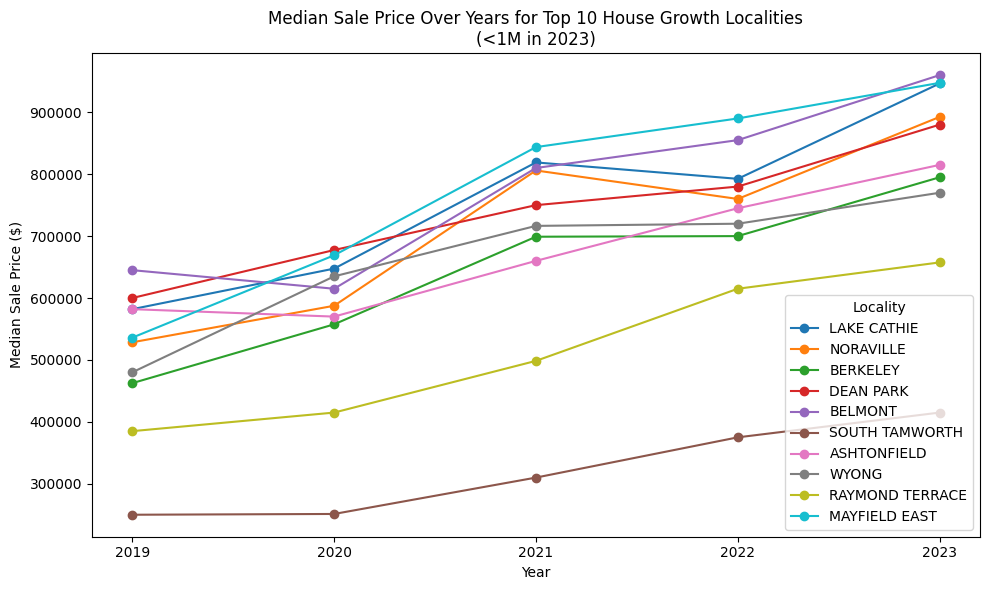

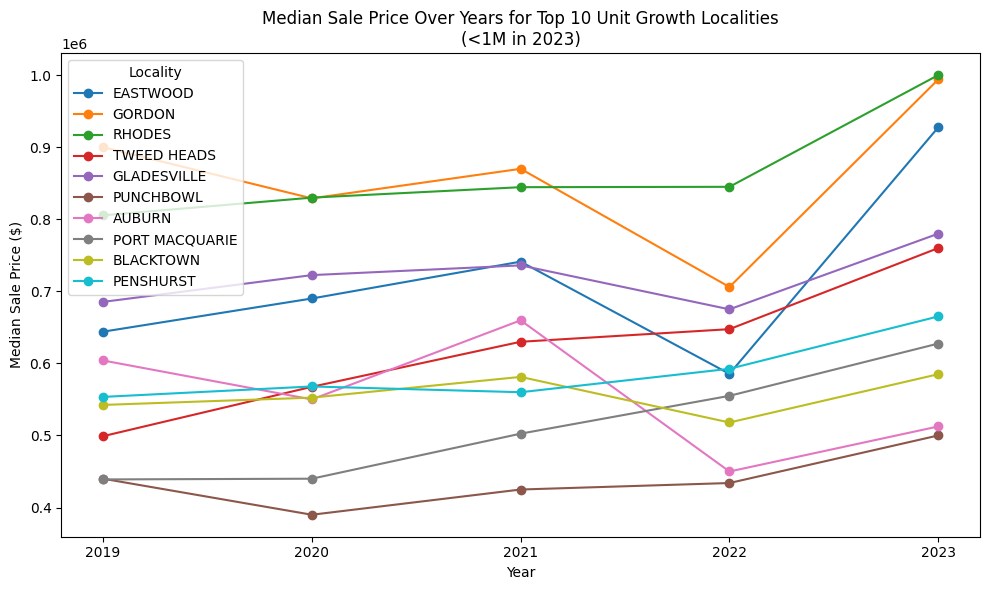

In [11]:
import matplotlib.pyplot as plt

def plot_top10_growth(top10_df, property_type):
    # Identify and sort the median‐price columns by year
    median_cols = sorted(
        [c for c in top10_df.columns if c.startswith('Median_')],
        key=lambda x: int(x.split('_')[1])
    )
    years = [int(c.split('_')[1]) for c in median_cols]

    # Plot each locality’s median price over time
    plt.figure(figsize=(10, 6))
    for locality in top10_df.index:
        plt.plot(
            years,
            top10_df.loc[locality, median_cols].values,
            marker='o',
            label=locality
        )

    # Chart formatting
    plt.xlabel('Year')
    plt.ylabel('Median Sale Price ($)')
    plt.title(
        f'Median Sale Price Over Years for Top 10 {property_type} Growth Localities\n(<1M in 2023)'
    )
    plt.xticks(years)
    plt.legend(title='Locality')
    plt.tight_layout()
    plt.show()

# Plot for Houses
plot_top10_growth(top10_house, 'House')

# Plot for Units
plot_top10_growth(top10_unit, 'Unit')

## Plotting distributions of house price growth rates against unit price growth rates (are unit growth rates worse than houses?)

House growth 2022–23: mean = -0.013762868785807585 median = -0.0120608952510793 n = 384
Unit  growth 2022–23: mean = 0.019388298521596913 median = 0.0 n = 96


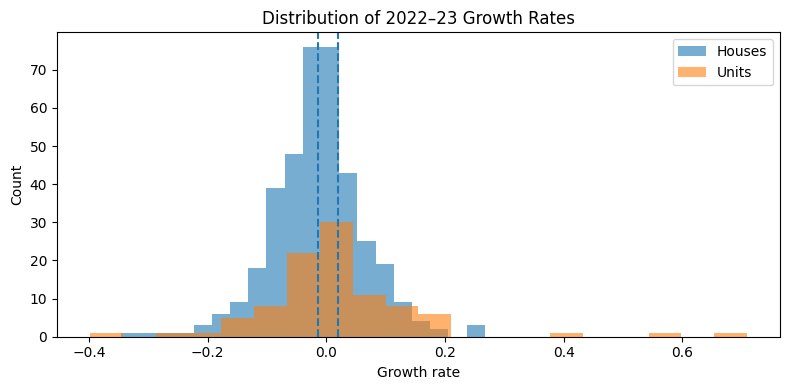

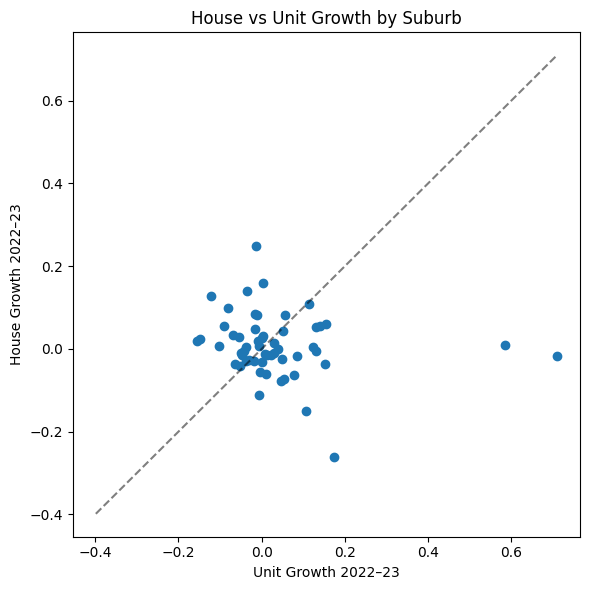

Paired t-test (H vs U): t=-1.033, p=0.306


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats  # for t-test, if you want

# 1. Pull out the 2022–23 growth series
h_growth = summary_house['Growth_2022-2023']
u_growth = summary_unit ['Growth_2022-2023']

# 2. Basic summaries
print("House growth 2022–23: mean =", h_growth.mean(), 
      "median =", h_growth.median(), "n =", len(h_growth))
print("Unit  growth 2022–23: mean =", u_growth.mean(), 
      "median =", u_growth.median(), "n =", len(u_growth))

# 3. Visualise distributions
plt.figure(figsize=(8,4))
plt.hist(h_growth, bins=20, alpha=0.6, label='Houses')
plt.hist(u_growth, bins=20, alpha=0.6, label='Units')
plt.axvline(h_growth.mean(), linestyle='--')
plt.axvline(u_growth.mean(), linestyle='--')
plt.legend()
plt.title('Distribution of 2022–23 Growth Rates')
plt.xlabel('Growth rate')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

# 4. Scatter: House vs Unit on a per-suburb basis
#    Only for suburbs that exist in both summaries:
common = summary_house.index.intersection(summary_unit.index)
plt.figure(figsize=(6,6))
plt.scatter(u_growth.loc[common], h_growth.loc[common])
lims = [min(u_growth.min(), h_growth.min()), max(u_growth.max(), h_growth.max())]
plt.plot(lims, lims, 'k--', alpha=0.5)
plt.xlabel('Unit Growth 2022–23')
plt.ylabel('House Growth 2022–23')
plt.title('House vs Unit Growth by Suburb')
plt.tight_layout()
plt.show()

# 5. (Optional) Paired t-test
tstat, pval = stats.ttest_rel(h_growth.loc[common], u_growth.loc[common])
print(f"Paired t-test (H vs U): t={tstat:.3f}, p={pval:.3f}")


In [13]:
import pandas as pd
from scipy import stats

# 1. Identify all growth columns in your summaries
growth_cols = [c for c in summary_house.columns if c.startswith('Growth_')]

# 2. Restrict to the same set of suburbs in both tables
common = summary_house.index.intersection(summary_unit.index)

# 3. Collect results
results = []
for col in growth_cols:
    h = summary_house.loc[common, col]
    u = summary_unit.loc[common, col]
    
    # Paired t-test
    tstat, pval = stats.ttest_rel(h, u)
    
    results.append({
        'Period': col.replace('Growth_', ''),
        'House mean': h.mean(),
        'Unit mean': u.mean(),
        't-stat': tstat,
        'p-value': pval
    })

# 4. Build a results DataFrame
results_df = pd.DataFrame(results).set_index('Period')

print(results_df)


           House mean  Unit mean     t-stat       p-value
Period                                                   
2018-2019   -0.008479  -0.045370   2.215078  3.099319e-02
2019-2020    0.108202   0.067003   2.349298  2.249648e-02
2020-2021    0.254702   0.066080  10.221968  3.125769e-14
2021-2022    0.021775  -0.013316   2.460664  1.709684e-02
2022-2023    0.008014   0.032177  -1.033039  3.061904e-01


Growth difference between houses and units is statistically significant in all years except 2022-23.

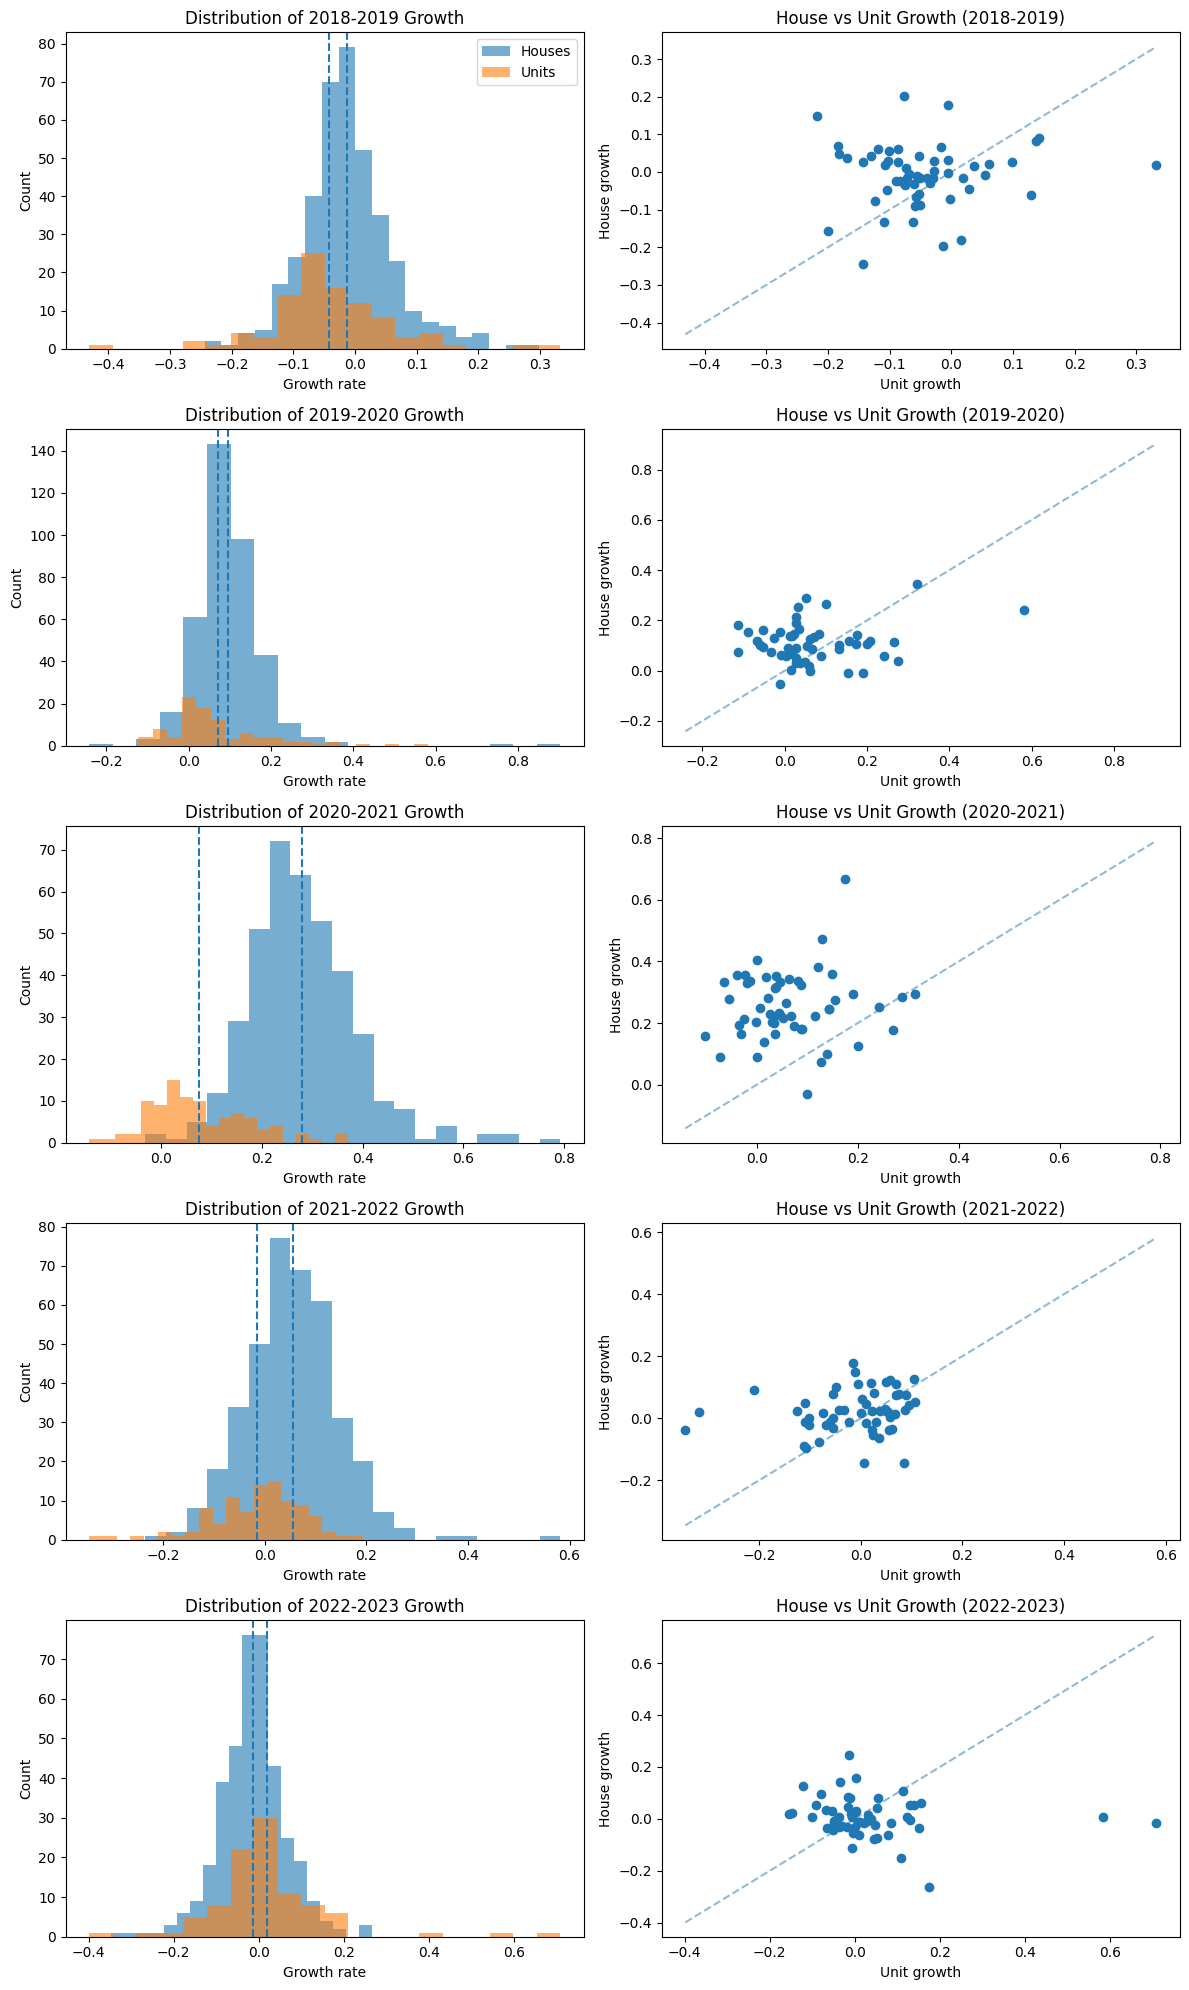

In [14]:
import matplotlib.pyplot as plt

# 1. Grab all your “Growth_YYYY–YYYY” columns
growth_cols = [c for c in summary_house.columns if c.startswith('Growth_')]

# 2. Find the suburbs common to both series (for scatter plots)
common = summary_house.index.intersection(summary_unit.index)

# 3. Create a figure: one row per period, 2 columns (histogram | scatter)
n = len(growth_cols)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(12, 4 * n))

for i, col in enumerate(growth_cols):
    period = col.replace('Growth_', '')
    
    # --- Left: overlaid histograms ---
    ax = axes[i, 0]
    ax.hist(summary_house[col], bins=20, alpha=0.6, label='Houses')
    ax.hist(summary_unit[col],  bins=20, alpha=0.6, label='Units')
    ax.axvline(summary_house[col].mean(), linestyle='--')
    ax.axvline(summary_unit[col].mean(), linestyle='--')
    ax.set_title(f'Distribution of {period} Growth')
    if i == 0:
        ax.legend()
    ax.set_xlabel('Growth rate')
    ax.set_ylabel('Count')
    
    # --- Right: House vs Unit scatter ---
    ax2 = axes[i, 1]
    ax2.scatter(summary_unit.loc[common, col],
                summary_house.loc[common, col])
    lims = [
        min(summary_unit[col].min(), summary_house[col].min()),
        max(summary_unit[col].max(), summary_house[col].max())
    ]
    ax2.plot(lims, lims, linestyle='--', alpha=0.5)
    ax2.set_title(f'House vs Unit Growth ({period})')
    ax2.set_xlabel('Unit growth')
    ax2.set_ylabel('House growth')

plt.tight_layout()
plt.show()


## Finding price per square metre (area <= 1000)

In [23]:
# 1. Compute Price_per_sqm and extract Year
df['Price_per_sqm'] = df['Sale Price'] / df['Area']
df['Year'] = df['Sale Date'].dt.year

# 2. Compute counts per Locality × Year and keep only Localities with ≥10 sales in every year
counts = (
    df
    .groupby(['Locality','Year'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)
valid_locs = counts[counts.min(axis=1) >= 10].index
df_filtered = df[df['Locality'].isin(valid_locs)]

# 3. Pivot average Price_per_sqm by Locality × Year
pivot_table = (
    df_filtered
    .groupby(['Locality','Year'], as_index=False)['Price_per_sqm']
    .mean()
    .pivot(index='Locality', columns='Year', values='Price_per_sqm')
)

# 4. Identify the most recent year and sort ascending
latest_year = pivot_table.columns.max()
sorted_by_latest = pivot_table.sort_values(by=latest_year, ascending=True)

# 5. Display
print(sorted_by_latest.to_markdown())


| Locality             |      2018 |      2019 |      2020 |      2021 |      2022 |       2023 |
|:---------------------|----------:|----------:|----------:|----------:|----------:|-----------:|
| NORTH ALBURY         |   414.081 |   430.373 |   384.768 |   601.101 |   747.655 |    529.011 |
| WINGHAM              |   426.948 |   470.489 |   512.731 |   565.047 |   742.296 |    599.763 |
| SOUTH TAMWORTH       |   455.361 |   583.224 |   535.586 |   628.582 |   851.726 |    625.582 |
| NORTH TAMWORTH       |   757.165 |   736.352 |   731.848 |   910.901 |  1229.95  |    753.348 |
| DUBBO                |   541.21  |   564.827 |   613.883 |   675.276 |   802.678 |    766.285 |
| GLOUCESTER           |   477.539 |   487.156 |   514.571 |   568.535 |   758.178 |    778.155 |
| CALALA               |   584.116 |   602.074 |   582.425 |   688.277 |   830.695 |    801.508 |
| TAREE                |   465.063 |   519.672 |   591.629 |   744.723 |   842.425 |    809.063 |
| RAYMOND TERRACE   

### For Greater Sydney

In [26]:
# 1. Drop any NaNs and get unique values
unique_locs = df['Locality'].dropna().unique()

# 2. (Optional) Sort alphabetically
unique_locs = sorted(unique_locs)

# 3. Display
print(unique_locs)

['ABBOTSBURY', 'ABBOTSFORD', 'ABERCROMBIE', 'ABERDARE', 'ABERDEEN', 'ABERGLASSLYN', 'ABERMAIN', 'ABERNETHY', 'ACACIA GARDENS', 'ADAMINABY', 'ADAMSTOWN', 'ADAMSTOWN HEIGHTS', 'ADELONG', 'AGNES BANKS', 'AIRDS', 'AKOLELE', 'ALBION PARK', 'ALBION PARK RAIL', 'ALBURY', 'ALDAVILLA', 'ALEXANDRIA', 'ALFORDS POINT', 'ALLAMBIE HEIGHTS', 'ALLAWAH', 'ALLWORTH', 'ALSTONVILLE', 'AMBARVALE', 'ANGLERS REACH', 'ANGOURIE', 'ANNA BAY', 'ANNANDALE', 'APPIN', 'ARAKOON', 'ARCADIA', 'ARCADIA VALE', 'ARGENTON', 'ARMIDALE', 'ARNCLIFFE', 'ARRAWARRA', 'ARRAWARRA HEADLAND', 'ARTARMON', 'ASHBURY', 'ASHBY', 'ASHCROFT', 'ASHFIELD', 'ASHFORD', 'ASHMONT', 'ASHTONFIELD', 'ASQUITH', 'ATTUNGA', 'AUBURN', 'AUSTINMER', 'AUSTRAL', 'AVALON BEACH', 'AVOCA BEACH', 'AVONDALE', 'AWABA', 'AYLMERTON', 'BALACLAVA', 'BALCOLYN', 'BALGOWLAH', 'BALGOWLAH HEIGHTS', 'BALGOWNIE', 'BALLINA', 'BALMAIN', 'BALMAIN EAST', 'BALMORAL', 'BALRANALD', 'BANGALOW', 'BANGOR', 'BANKSIA', 'BANKSMEADOW', 'BANKSTOWN', 'BANORA POINT', 'BAR BEACH', 'BARADIN

I found a list of greater sydney suburbs here: https://en.wikipedia.org/wiki/List_of_Sydney_suburbs

Taking the intersection of that list and those Localities i have:

In [ ]:
gs_suburbs = [
    "Abbotsbury", "Abbotsford", "Acacia Gardens", "Agnes Banks", "Airds", "Alexandria",
    "Alfords Point", "Allambie Heights", "Allawah", "Ambarvale", "Angus", "Annandale",
    "Annangrove", "Arcadia", "Arncliffe", "Arndell Park", "Artarmon", "Ashbury", "Ashcroft",
    "Ashfield", "Asquith", "Auburn", "Austral", "Avalon Beach", "Badgerys Creek", "Balgowlah",
    "Balgowlah Heights", "Balmain", "Balmain East", "Bangor", "Banksia", "Banksmeadow", "Bankstown",
    "Bankstown Aerodrome", "Barangaroo", "Barden Ridge", "Bardia", "Bardwell Park", "Bardwell Valley",
    "Bass Hill", "Baulkham Hills", "Bayview", "Beacon Hill", "Beaconsfield", "Beaumont Hills",
    "Beecroft", "Belfield", "Bella Vista", "Bellevue Hill", "Belmore", "Belrose", "Berala",
    "Berkshire Park", "Berowra", "Berowra Heights", "Berowra Waters", "Berrilee", "Beverley Park",
    "Beverly Hills", "Bexley", "Bexley North", "Bidwill", "Bilgola Beach", "Bilgola Plateau",
    "Birchgrove", "Birrong", "Blackett", "Blacktown", "Blair Athol", "Blairmount", "Blakehurst",
    "Bligh Park", "Bondi", "Bondi Beach", "Bondi Junction", "Bonnet Bay", "Bonnyrigg",
    "Bonnyrigg Heights", "Bossley Park", "Botany", "Bow Bowing", "Box Hill", "Bradbury",
    "Bradfield", "Breakfast Point", "Brighton-Le-Sands", "Bringelly", "Bronte", "Brooklyn",
    "Brookvale", "Bundeena", "Bungarribee", "Burraneer", "Burwood", "Burwood Heights", "Busby",
    "Cabarita", "Cabramatta", "Cabramatta West", "Caddens", "Cambridge Gardens", "Cambridge Park",
    "Camden", "Camden South", "Camellia", "Cammeray", "Campbelltown", "Camperdown", "Campsie",
    "Canada Bay", "Canley Heights", "Canley Vale", "Canoelands", "Canterbury", "Caringbah",
    "Caringbah South", "Carlingford", "Carlton", "Carnes Hill", "Carramar", "Carss Park",
    "Cartwright", "Castle Cove", "Castle Hill", "Castlecrag", "Castlereagh", "Casula", "Catherine Field",
    "Cattai", "Cawdor", "Cecil Hills", "Cecil Park", "Centennial Park", "Central Business District",
    "Chatswood", "Chatswood West", "Cheltenham", "Cherrybrook", "Chester Hill", "Chifley",
    "Chippendale", "Chipping Norton", "Chiswick", "Chullora", "Church Point", "Claremont Meadows",
    "Clarendon", "Clareville", "Claymore", "Clemton Park", "Clontarf", "Clovelly", "Clyde",
    "Coasters Retreat", "Cobbitty", "Colebee", "Collaroy", "Collaroy Plateau", "Colyton", "Como",
    "Concord", "Concord West", "Condell Park", "Connells Point", "Constitution Hill", "Coogee",
    "Cornwallis", "Cottage Point", "Cowan", "Cranebrook", "Cremorne", "Cremorne Point", "Cromer",
    "Cronulla", "Crows Nest", "Croydon", "Croydon Park", "Cumberland Reach", "Curl Curl", "Currans Hill",
    "Currawong Beach", "Daceyville", "Dangar Island", "Darling Point", "Darlinghurst", "Darlington",
    "Davidson", "Dawes Point", "Dean Park", "Dee Why", "Denham Court", "Denistone", "Denistone East",
    "Denistone West", "Dharruk", "Dolans Bay", "Dolls Point", "Doonside", "Double Bay", "Dover Heights",
    "Drummoyne", "Duffys Forest", "Dulwich Hill", "Dundas", "Dundas Valley", "Dural", "Eagle Vale",
    "Earlwood", "East Gordon", "East Hills", "East Killara", "East Kurrajong", "East Lindfield",
    "East Ryde", "Eastern Creek", "Eastgardens", "Eastlakes", "Eastwood", "Ebenezer", "Edensor Park",
    "Edgecliff", "Edmondson Park", "Elanora Heights", "Elderslie", "Elizabeth Bay", "Elizabeth Hills",
    "Ellis Lane", "Elvina Bay", "Emerton", "Emu Heights", "Emu Plains", "Enfield", "Engadine",
    "Englorie Park", "Enmore", "Epping", "Ermington", "Erskine Park", "Erskineville", "Eschol Park",
    "Eveleigh", "Fairfield", "Fairfield East", "Fairfield Heights", "Fairfield West", "Fairlight",
    "Fiddletown", "Five Dock", "Flemington", "Forest Glen", "Forest Lodge", "Forestville",
    "Freemans Reach", "Frenchs Forest", "Freshwater", "Gables", "Galston", "Georges Hall",
    "Gilead", "Girraween", "Gladesville", "Glebe", "Gledswood Hills", "Glen Alpine", "Glendenning",
    "Glenfield", "Glenhaven", "Glenmore Park", "Glenorie", "Glenwood", "Glossodia", "Gordon",
    "Grantham Farm", "Granville", "Grasmere", "Grays Point", "Great Mackerel Beach", "Green Valley",
    "Greenacre", "Greendale", "Greenfield Park", "Greenhills Beach", "Greenwich", "Green Square",
    "Gregory Hills", "Greystanes", "Grose Vale", "Grose Wold", "Guildford", "Guildford West",
    "Gymea", "Gymea Bay", "Haberfield", "Hammondville", "Harrington Park", "Harris Park",
    "Hassall Grove", "Haymarket", "Heathcote", "Hebersham", "Heckenberg", "Henley", "Hillsdale",
    "Hinchinbrook", "Hobartville", "Holroyd", "Holsworthy", "Homebush", "Homebush West", "Horningsea Park",
    "Hornsby", "Hornsby Heights", "Horsley Park", "Hoxton Park", "Hunters Hill", "Huntingwood",
    "Huntleys Cove", "Huntleys Point", "Hurlstone Park", "Hurstville", "Hurstville Grove", "Illawong",
    "Ingleburn", "Ingleside", "Jamisontown", "Jannali", "Jordan Springs", "Kangaroo Point", "Kareela",
    "Kearns", "Kellyville", "Kellyville Ridge", "Kemps Creek", "Kensington", "Kenthurst", "Kentlyn",
    "Killara", "Killarney Heights", "Kings Langley", "Kings Park", "Kingsford", "Kingsgrove",
    "Kingswood", "Kingswood Park", "Kirkham", "Kirrawee", "Kirribilli", "Kogarah", "Kogarah Bay",
    "Ku-ring-gai Chase", "Kurmond", "Kurnell", "Kurraba Point", "Kurrajong", "Kurrajong Hills",
    "Kyeemagh", "Kyle Bay", "La Perouse", "Lakemba", "Lalor Park", "Lane Cove", "Lane Cove North",
    "Lane Cove West", "Lansdowne", "Lansvale", "Laughtondale", "Lavender Bay", "Leets Vale",
    "Leichhardt", "Len Waters Estate", "Leonay", "Leppington", "Lethbridge Park", "Leumeah",
    "Lewisham", "Liberty Grove", "Lidcombe", "Lilli Pilli", "Lilyfield", "Lindfield", "Linley Point",
    "Little Bay", "Liverpool", "Llandilo", "Loftus", "Londonderry", "Long Point", "Longueville",
    "Lovett Bay", "Lower Portland", "Lucas Heights", "Luddenham", "Lugarno", "Lurnea", "Macarthur",
    "Macquarie Fields", "Macquarie Links", "Macquarie Park", "Maianbar", "Malabar", "Manly",
    "Manly Vale", "Maraylya", "Marayong", "Maroota", "Maroubra", "Marrickville", "Marsden Park",
    "Marsfield", "Mascot", "Matraville", "Mays Hill", "McCarrs Creek", "McGraths Hill", "McMahons Point",
    "Meadowbank", "Melonba", "Melrose Park", "Menai", "Menangle Park", "Merrylands", "Merrylands West",
    "Middle Cove", "Middle Dural", "Middleton Grange", "Miller", "Millers Point", "Milperra",
    "Milsons Passage", "Milsons Point", "Minchinbury", "Minto", "Minto Heights", "Miranda", "Mona Vale",
    "Monterey", "Moore Park", "Moorebank", "Morning Bay", "Mortdale", "Mortlake", "Mosman",
    "Mount Annan", "Mount Colah", "Mount Druitt", "Mount Kuring-Gai", "Mount Lewis", "Mount Pritchard",
    "Mount Vernon", "Mulgoa", "Mulgrave", "Narellan", "Narellan Vale", "Naremburn", "Narrabeen",
    "Narraweena", "Narwee", "Nelson", "Neutral Bay", "Newington", "Newport", "Newtown", "Nirimba Fields",
    "Normanhurst", "North Balgowlah", "North Bondi", "North Curl Curl", "North Epping", "North Kellyville",
    "North Manly", "North Narrabeen", "North Parramatta", "North Richmond", "North Rocks", "North Ryde",
    "North St Ives", "North St Marys", "North Strathfield", "North Sydney", "North Turramurra",
    "North Wahroonga", "North Willoughby", "Northbridge", "Northmead", "Northwood", "Norwest",
    "Oakhurst", "Oakville", "Oatlands", "Oatley", "Old Guildford", "Old Toongabbie", "Oran Park",
    "Orchard Hills", "Oxford Falls", "Oxley Park", "Oyster Bay", "Paddington", "Padstow", "Padstow Heights",
    "Pagewood", "Palm Beach", "Panania", "Parklea", "Parramatta", "Peakhurst", "Peakhurst Heights",
    "Pemulwuy", "Pendle Hill", "Pennant Hills", "Penrith", "Penshurst", "Petersham", "Phillip Bay",
    "Picnic Point", "Pitt Town", "Pitt Town Bottoms", "Pleasure Point", "Plumpton", "Point Piper",
    "Port Botany", "Port Hacking", "Potts Hill", "Potts Point", "Prairiewood", "Prestons", "Prospect",
    "Punchbowl", "Putney", "Pymble", "Pyrmont", "Quakers Hill", "Queens Park", "Queenscliff", "Raby",
    "Ramsgate", "Ramsgate Beach", "Randwick", "Redfern", "Regents Park", "Regentville", "Revesby",
    "Revesby Heights", "Rhodes", "Richards", "Richmond", "Richmond Lowlands", "Riverstone", "Riverview",
    "Riverwood", "Rockdale", "Rodd Point", "Rookwood", "Rooty Hill", "Ropes Crossing", "Rose Bay",
    "Rosebery", "Rosehill", "Roselands", "Rosemeadow", "Roseville", "Roseville Chase", "Rossmore",
    "Rouse Hill", "Royal National Park", "Rozelle", "Ruse", "Rushcutters Bay", "Russell Lea",
    "Rydalmere", "Ryde", "Sackville", "Sackville North", "Sadleir", "Sandringham", "Sandy Point",
    "Sans Souci", "Scheyville", "Schofields", "Scotland Island", "Seaforth", "Sefton", "Seven Hills",
    "Shalvey", "Shanes Park", "Silverwater", "Singletons Mill", "Smeaton Grange", "Smithfield",
    "South Coogee", "South Granville", "South Hurstville", "South Maroota", "South Penrith",
    "South Turramurra", "South Wentworthville", "South Windsor", "Spring Farm", "St Andrews",
    "St Clair", "St Helens Park", "St Ives", "St Ives Chase", "St James", "St Johns Park", "St Leonards",
    "St Marys", "St Peters", "Stanhope Gardens", "Stanmore", "Strathfield", "Strathfield South",
    "Summer Hill", "Surry Hills", "Sutherland", "Sydenham", "Sydney Olympic Park", "Sylvania",
    "Sylvania Waters", "Tallawong", "Tamarama", "Taren Point", "Telopea", "Tempe", "Tennyson",
    "Tennyson Point", "Terrey Hills", "The Ponds", "The Rocks", "The Slopes", "Thornleigh",
    "Toongabbie", "Tregear", "Turramurra", "Turrella", "Ultimo", "Varroville", "Vaucluse",
    "Villawood", "Vineyard", "Voyager Point", "Wahroonga", "Waitara", "Wakeley", "Wallacia",
    "Wareemba", "Warrawee", "Warriewood", "Warwick Farm", "Waterfall", "Waterloo", "Watsons Bay",
    "Wattle Grove", "Waverley", "Waverton", "Wedderburn", "Wentworth Point", "Wentworthville",
    "Werrington", "Werrington County", "Werrington Downs", "West Hoxton", "West Killara",
    "West Pennant Hills", "West Pymble", "West Ryde", "Westleigh", "Westmead", "Wetherill Park",
    "Whalan", "Whale Beach", "Wheeler Heights", "Wilberforce", "Wiley Park", "Willmot", "Willoughby",
    "Willoughby East", "Windsor", "Windsor Downs", "Winston Hills", "Wisemans Ferry", "Wolli Creek",
    "Wollstonecraft", "Woodbine", "Woodcroft", "Woodpark", "Woollahra", "Woolloomooloo",
    "Woolooware", "Woolwich", "Woronora", "Woronora Heights", "Wynyard", "Yagoona", "Yarramundi",
    "Yarrawarrah", "Yennora", "Yowie Bay"
]

gs_suburbs = [s.upper() for s in gs_suburbs]

# 4. Filter the DataFrame to include only the suburbs in gs_suburbs
df_gs = df[df['Locality'].isin(gs_suburbs)]



['WOLLI CREEK' 'ROCKDALE' 'BOTANY' 'BANKSIA' 'MASCOT' 'PAGEWOOD'
 'SANS SOUCI' 'ARNCLIFFE' 'EASTLAKES' 'BARDWELL VALLEY' 'HILLSDALE'
 'BRIGHTON-LE-SANDS' 'BEXLEY' 'DACEYVILLE' 'BEXLEY NORTH' 'CARLTON'
 'MONTEREY' 'TURRELLA' 'RAMSGATE' 'SANDRINGHAM' 'EASTGARDENS'
 'BARDWELL PARK' 'KINGSGROVE' 'RAMSGATE BEACH' 'ROSEBERY' 'DOLLS POINT'
 'KYEEMAGH' 'KOGARAH' 'BANKSMEADOW' 'SCHOFIELDS' 'ROPES CROSSING'
 'KINGS LANGLEY' 'BLACKTOWN' 'GLENWOOD' 'KINGS PARK' 'SEVEN HILLS'
 'STANHOPE GARDENS' 'THE PONDS' 'MELONBA' 'HASSALL GROVE' 'TALLAWONG'
 'DEAN PARK' 'ROUSE HILL' 'KELLYVILLE RIDGE' 'SHALVEY' 'GLENDENNING'
 'MARSDEN PARK' 'QUAKERS HILL' 'MARAYONG' 'LALOR PARK' 'PARKLEA'
 'PLUMPTON' 'WILLMOT' 'ROOTY HILL' 'BLACKETT' 'RIVERSTONE' 'COLEBEE'
 'OAKHURST' 'PROSPECT' 'LETHBRIDGE PARK' 'MINCHINBURY' 'WOODCROFT'
 'HEBERSHAM' 'DOONSIDE' 'GRANTHAM FARM' 'ACACIA GARDENS' 'WHALAN'
 'BIDWILL' 'BUNGARRIBEE' 'DHARRUK' 'TREGEAR' 'EMERTON' 'MOUNT DRUITT'
 'EASTERN CREEK' 'TOONGABBIE' 'NIRIMBA FIELDS' 'CROYDON'

In [ ]:
counts = (
    df_gs
    .groupby(['Locality','Year'])
    .size()
    .unstack(fill_value=0)
    .sort_index(axis=1)
)
valid_locs = counts[counts.min(axis=1) >= 10].index
df__gs_filtered = df_gs[df_gs['Locality'].isin(valid_locs)]

pivot_table = (
    df__gs_filtered
    .groupby(['Locality','Year'], as_index=False)['Price_per_sqm']
    .mean()
    .pivot(index='Locality', columns='Year', values='Price_per_sqm')
)

latest_year = pivot_table.columns.max()
sorted_by_latest = pivot_table.sort_values(by=latest_year, ascending=True)

print(sorted_by_latest.to_markdown())

| Locality             |      2018 |      2019 |      2020 |     2021 |      2022 |      2023 |
|:---------------------|----------:|----------:|----------:|---------:|----------:|----------:|
| TREGEAR              |   772.595 |   712.572 |   816.899 |  1035.64 |   992.649 |   1028.15 |
| LETHBRIDGE PARK      |   841.849 |   722.416 |   881.058 |  1050.53 |  1080.23  |   1092.49 |
| LAKEMBA              |  1436.24  |  1574.29  |   966.324 |  1386.7  |  1435.82  |   1167.85 |
| HEBERSHAM            |  1009.42  |   921.336 |  1070.23  |  1120.8  |  1297.85  |   1204.77 |
| AMBARVALE            |   857.751 |   861.358 |   944.913 |  1071.4  |  1204.8   |   1206.4  |
| ESCHOL PARK          |   949.533 |   915.662 |   996.203 |  1115.7  |  1371.93  |   1225.11 |
| EAGLE VALE           |   980.26  |  1011.53  |   995.832 |  1224.15 |  1384.52  |   1285.14 |
| RUSE                 |   964.529 |   915.269 |   987.437 |  1166.32 |  1263.19  |   1290.52 |
| CAMDEN SOUTH         |  1401.05  |   9

In [36]:
import pandas as pd

# 1. Pivot table of average Price_per_sqm per Locality per Year
pivot = (
    df_gs
    .groupby(['Locality', 'Year'])['Price_per_sqm']
    .mean()
    .unstack()                           # Locality rows × Year columns
    .sort_index(axis=1)                 # order columns chronologically
)
pivot.columns.name = 'AvgPrice_sqm'

# 2. Year-on-year growth rates (as decimals)
years = pivot.columns.tolist()
growth = pivot.pct_change(axis=1)       # % change along the year axis
growth = growth.iloc[:, 1:]             # drop the first year (no prior year to compare)
growth.columns = [
    f'Growth_{years[i-1]}_{years[i]}' 
    for i in range(1, len(years))
]

# 3. Combine averages and growth into one summary table
summary = pd.concat([pivot, growth], axis=1)

# 4. (Optional) round for readability
summary = summary.round(4)

# Sort the summary by the 2022–2023 growth rate, highest first
sorted_summary = summary.sort_values(
    by='Growth_2022_2023', 
    ascending=False
)

# Peek at the top performers
print(sorted_summary.head())


                       2018        2019        2020        2021        2022  \
Locality                                                                      
QUEENSCLIFF       2672.6641   5628.6497   5326.4416   7415.9935   3977.0526   
CAMPERDOWN       92830.0089  29435.1051  49655.9937  77315.3529  49404.4939   
KANGAROO POINT    3995.7379   3145.6378   4209.2988   4433.4727   2960.2056   
MCMAHONS POINT   17931.2580  19542.1853  12785.1675  16531.2458  10917.7677   
SCOTLAND ISLAND   1484.6235   1867.6805         NaN         NaN         NaN   

                        2023  Growth_2018_2019  Growth_2019_2020  \
Locality                                                           
QUEENSCLIFF        9915.7374            1.1060           -0.0537   
CAMPERDOWN       114418.2959           -0.6829            0.6870   
KANGAROO POINT     6185.4460           -0.2128            0.3381   
MCMAHONS POINT    18437.9634            0.0898           -0.3458   
SCOTLAND ISLAND    3024.3261          

C:\Users\johnn\AppData\Local\Temp\ipykernel_29396\2532941619.py:15: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  growth = pivot.pct_change(axis=1)       # % change along the year axis


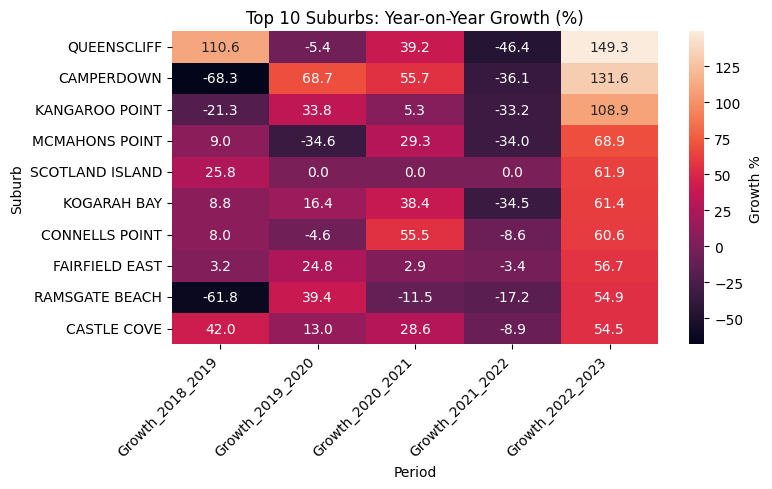

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Safely pick out your growth columns
growth_cols = [
    c for c in summary.columns 
    if isinstance(c, str) and c.startswith('Growth_')
]

# 2. Grab the top 10 suburbs by Growth_2022_2023
top10 = sorted_summary.index[:10]

# 3. Slice out just those rows & growth columns
sub = summary.loc[top10, growth_cols]

# 4. Plot a heatmap of % growth
plt.figure(figsize=(8, 5))
sns.heatmap(
    sub * 100,            # convert to %
    annot=True,           # show numbers
    fmt=".1f",            # one decimal place
    cbar_kws={'label': 'Growth %'},
    yticklabels=True
)
plt.title('Top 10 Suburbs: Year-on-Year Growth (%)')
plt.ylabel('Suburb')
plt.xlabel('Period')
plt.yticks(rotation=0)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Price vs Growth')

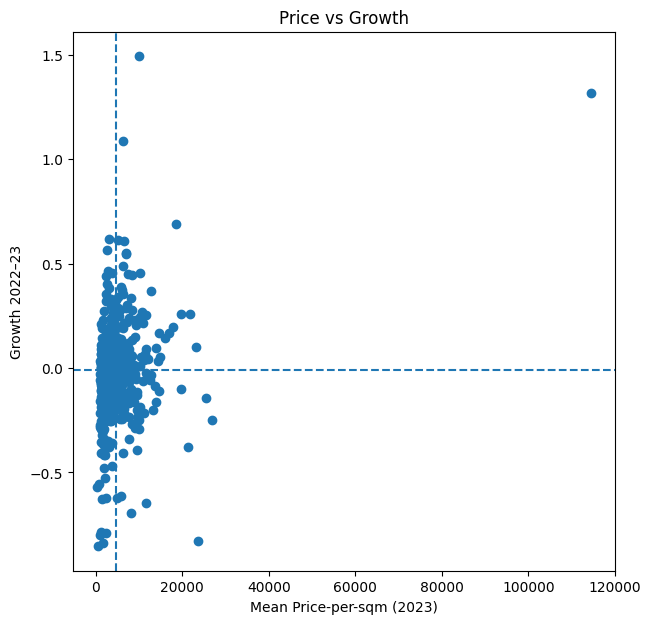

In [43]:
# assume ‘2023’ column is present
x = summary[2023]
y = summary['Growth_2022_2023']
fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(x, y)
ax.axvline(x.mean(), linestyle='--')
ax.axhline(y.mean(), linestyle='--')
ax.set_xlabel('Mean Price-per-sqm (2023)')
ax.set_ylabel('Growth 2022–23')
ax.set_title('Price vs Growth')

Text(0.5, 1.0, 'Top 50 Suburbs by Price-per-sqm Growth (2022–23)')

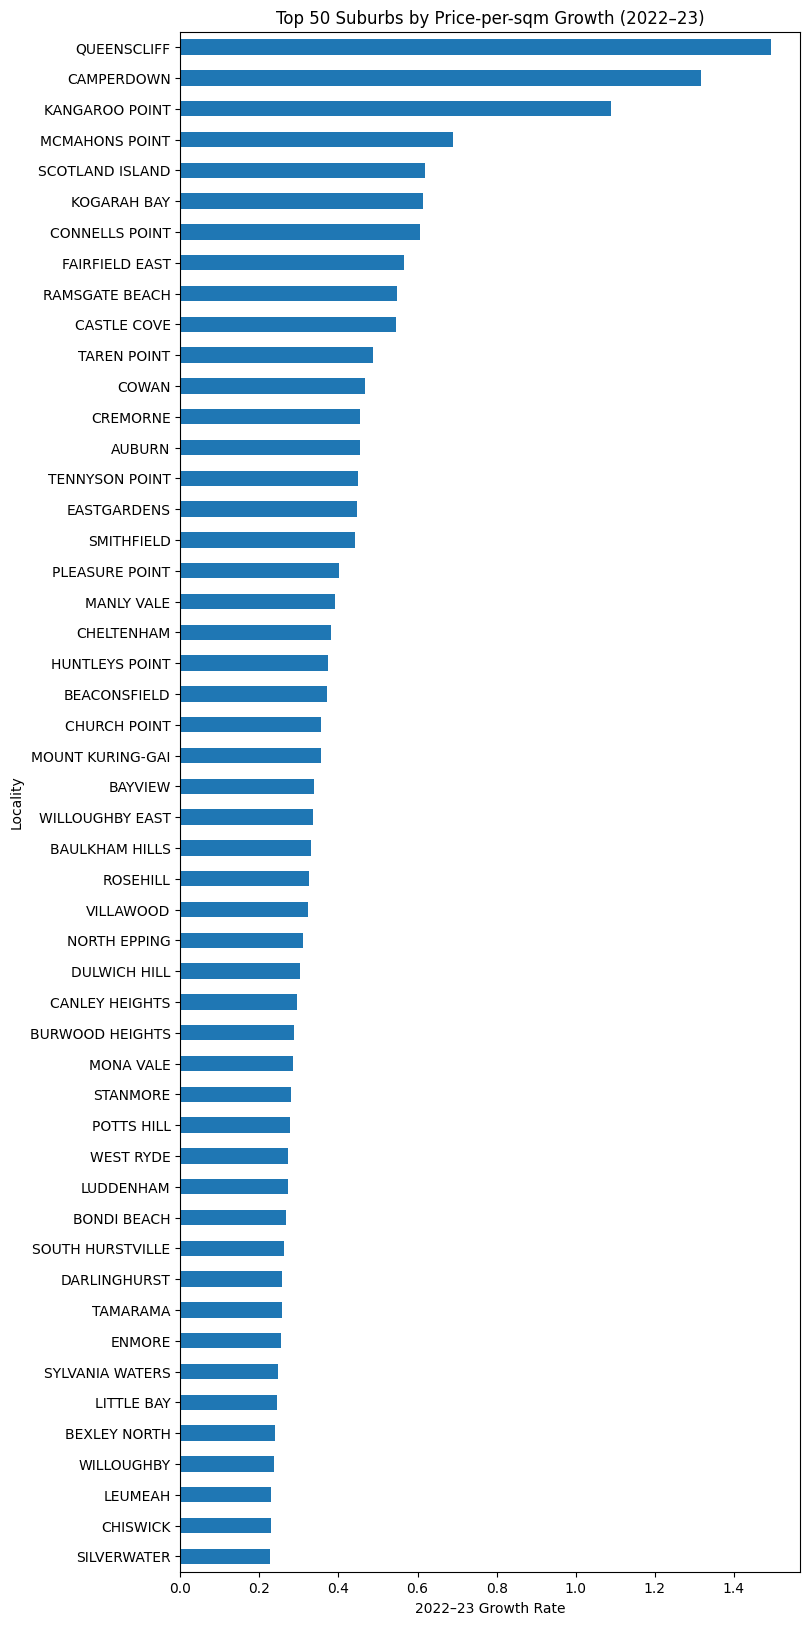

In [47]:
top_n = 50
top_growth = sorted_summary['Growth_2022_2023'].head(top_n)
ax = top_growth.plot.barh(figsize=(8, 20))
ax.invert_yaxis()  # highest at top
ax.set_xlabel('2022–23 Growth Rate')
ax.set_title(f'Top {top_n} Suburbs by Price-per-sqm Growth (2022–23)')